In [95]:
%matplotlib inline
import os
import random

In [96]:
import numpy as np
import json
import matplotlib.pyplot

In [97]:
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE
print("installed")

installed


In [98]:
model=input()

gender


In [99]:
pickle_file='pcafeatures_'+model+'.p'

In [100]:
images, pca_features, pca = pickle.load(open(pickle_file, 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: ../../Dataset/img_align_celeba/1001.jpg, features: 189.27,-12.06,35.08,-10.81... 
image: ../../Dataset/img_align_celeba/1002.jpg, features: -300.70,-42.41,15.71,-51.65... 
image: ../../Dataset/img_align_celeba/1003.jpg, features: -345.76,-50.23,-17.47,-32.36... 
image: ../../Dataset/img_align_celeba/1004.jpg, features: 194.16,6.15,57.82,-54.60... 
image: ../../Dataset/img_align_celeba/1005.jpg, features: 157.20,122.98,50.95,4.29... 


In [86]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 36.599269
[t-SNE] Computed conditional probabilities in 0.060s
[t-SNE] Iteration 50: error = 70.4605255, gradient norm = 0.1555702 (50 iterations in 0.522s)
[t-SNE] Iteration 100: error = 71.1487503, gradient norm = 0.1252059 (50 iterations in 0.325s)
[t-SNE] Iteration 150: error = 72.1487198, gradient norm = 0.0771325 (50 iterations in 0.382s)
[t-SNE] Iteration 200: error = 70.9625854, gradient norm = 0.1371240 (50 iterations in 0.368s)
[t-SNE] Iteration 250: error = 71.6627350, gradient norm = 0.1138390 (50 iterations in 0.311s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.662735
[t-SNE] Iteration 300: error = 1.4840832, gradient norm = 0.0063409 (50 iterations in 0.488s)
[t-SNE] Iteration 350: error = 1.2008442, gradient norm = 0.0038

In [87]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results. Adjust `width` and `height` to set the size in pixels of the full image, and set `max_dim` to the pixel size (on the largest size) to scale images to.

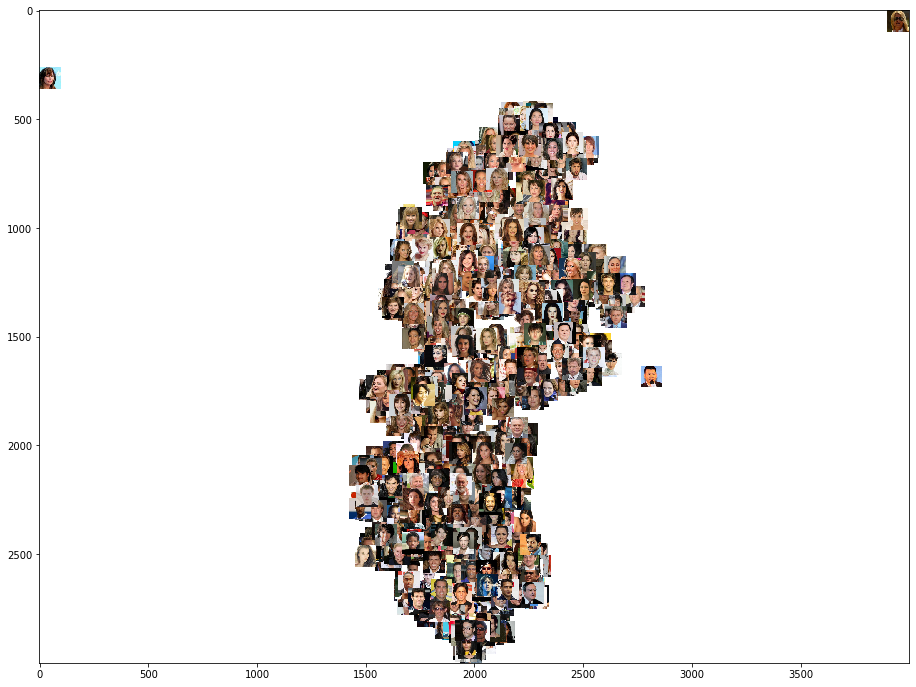

In [88]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

You can save the image to disk:

In [89]:
full_image.save("example-tSNE_"+model+".png")

Now that we have generated our t-SNE, one more nice thing we can optionally do is to take the 2d embedding and assign it to a grid, using [RasterFairy](https://github.com/Quasimondo/RasterFairy). We can optionally choose a grid size of rows (`nx`) and columns (`ny`), which should be equal to the number of images you have. If it is less, then you can simply cut the `tsne` and `images` lists to be equal to `nx * ny`.

If you omit the `target=(nx, ny)` argument, RasterFairy will automatically choose an optimal grid size to be as square-shaped as possible. RasterFairy also has options for embedding them in a grid with irregular borders as well (see the GitHub page for more details).

You can also save the t-SNE points and their associated image paths for further processing in another environment.

In [90]:
tsne_path = "pca_features_"+model+".json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to pca_features_gender.json


In [91]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))
assignmentArray = np.array(grid_assignment[0])

In [92]:
import csv
with open('theCSV.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    for row in range(0,len(assignmentArray)):
        num = assignmentArray[row]
        x = num[0]
        y = num[1]
        writer.writerow([x, y])

Now finally, we can make a new image of our grid. Set the `tile_width` and `tile_height` variables according to how big you want the individual tile images to be. The resolution of the output image is `tile_width * nx` x `tile_height * ny`. The script will automatically center-crop all the tiles to match the aspect ratio of `tile_width / tile_height`.

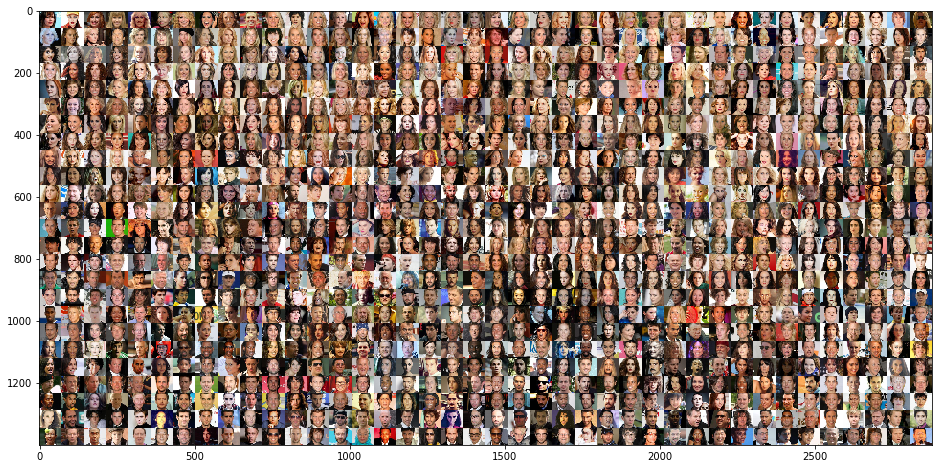

In [93]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

Finally, we can save the gridded t-SNE to disk as well.

In [94]:
grid_image.save("example-tSNE-grid_"+model+".jpg")